In [2]:
import tensorflow as tf
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Concatenate, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [3]:
token_file = 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flickr8k_text/Flickr8k.token.txt'

In [4]:
captions = open(token_file, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [5]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [5]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
Flicker8k_images = 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flicker8k_Dataset/'

In [7]:
# Contains all the images
img = glob.glob(Flicker8k_images+'*.jpg')

In [8]:
img[:5]

['C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [8]:
train_images_file = 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flickr8k_text/Flickr_8k.trainImages.txt'

In [9]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [10]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(Flicker8k_images):] in l:
            temp.append(i)
    return temp

In [11]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [33]:
val_images_file = 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [34]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [19]:
test_images_file = 'C:/Users/arjav/OneDrive/Desktop/Flicker8k_Data/Flickr8k_text/Flickr_8k.testImages1.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [21]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

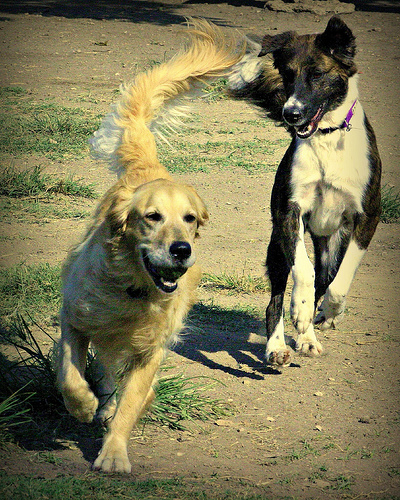

In [17]:
Image.open(train_img[67])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. Since we dont want Classification,This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [18]:
def preprocessing_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [19]:
def preprocessing(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocessing_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


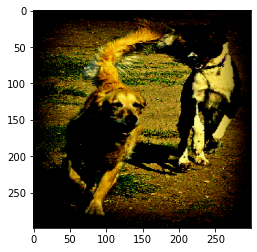

In [20]:
plt.imshow(np.squeeze(preprocessing(train_img[67])))

In [12]:
model = InceptionV3(weights='imagenet')

In [13]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

keras_new = Model(new_input, hidden_layer)

In [23]:
imagenet = keras_new.predict(preprocessing(train_img[67]))

In [24]:
imagenet.shape

(1, 2048)

In [25]:
def encoding(image):
    image = preprocessing(image)
    temp_encode = keras_new.predict(image)
    temp_encode = np.reshape(temp_encode, temp_encode.shape[1])
    return temp_encode

In [26]:
encoding_train = {}
#Once encoded just load .p file
#for img in tqdm(train_img):
#    encoding_train[img[len(Flicker8k_images):]] = encoding(img)

In [27]:
#with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
#    pickle.dump(encoding_train, encoded_pickle) 

In [14]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [15]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [30]:
encoding_test = {}
#Once encoded just load .p file
#for img in tqdm(test_img):
#    encoding_test[img[len(Flicker8k_images):]] = encoding(img)

In [31]:
#with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
#    pickle.dump(encoding_test, encoded_pickle) 

In [16]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [22]:
encoding_test[test_img[0][len(Flicker8k_images):]].shape

(2048,)

In [28]:
train_data = {}
for i in train_img:
    if i[len(Flicker8k_images):] in d:
        train_data[i] = d[i[len(Flicker8k_images):]]

In [29]:
len(train_data)

6000

In [35]:
val_data = {}
for i in val_img:
    if i[len(Flicker8k_images):] in d:
        val_data[i] = d[i[len(Flicker8k_images):]]

In [36]:
len(val_data)

1000

In [37]:
test_data = {}
for i in test_img:
    if i[len(Flicker8k_images):] in d:
        test_data[i] = d[i[len(Flicker8k_images):]]

In [38]:
len(test_data)

1000

Calculating the unique words in the vocabulary.

In [39]:
caps = []
for key, val in train_data.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [40]:
words = [i.split() for i in caps]

In [41]:
unique = []
for i in words:
    unique.extend(i)

In [42]:
unique = list(set(unique))

In [43]:
# with open("unique.p", "wb") as pickle_d:
#     pickle.dump(unique, pickle_d) 

In [44]:
unique = pickle.load(open('unique.p', 'rb'))

In [45]:
len(unique)

8256

Mapping the unique words to indices and vice-versa

In [46]:
word2idx = {val:index for index, val in enumerate(unique)}

In [47]:
word2idx['<start>']

7214

In [48]:
idx2word = {index:val for index, val in enumerate(unique)}

In [49]:
idx2word[5553]

'waters'

Calculating the maximum length among all the captions

In [50]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [51]:
len(unique), max_len

(8256, 40)

In [52]:
vocab_size = len(unique)

In [53]:
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [55]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [56]:
for key, val in train_data.items():
    for i in val:
        f.write(key[len(Flicker8k_images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [57]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [58]:
len(df)

30000

In [59]:
c = [i for i in df['captions']]
len(c)

30000

In [60]:
imgs = [i for i in df['image_id']]

In [61]:
eg = c[-1]
eg, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [62]:
for i in eg.split():
    print (i, "=>", word2idx[i])

<start> => 7214
Woman => 5509
writing => 1834
on => 586
a => 3007
pad => 1981
in => 6615
room => 7304
with => 3047
gold => 4255
, => 7972
decorated => 5960
walls => 2621
. => 231
<end> => 3262


In [63]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [64]:
samples_per_epoch

383454

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

RNN network is used.

In [54]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [55]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [56]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])
image_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 300)               614700    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 300)           0         
Total params: 614,700
Trainable params: 614,700
Non-trainable params: 0
_________________________________________________________________


Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [57]:
language_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])
language_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           2476800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           570368    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 300)           77100     
Total params: 3,124,268
Trainable params: 3,124,268
Non-trainable params: 0
_________________________________________________________________


Merging the models and creating a softmax classifier

In [58]:
#Merging the models and creating a softmax classifier
conca = Concatenate()([image_model.output, language_model.output])
x = Bidirectional(LSTM(256, return_sequences=False))(conca)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
Ready_model = Model(inputs=[image_model.input, language_model.input], outputs = out)

In [59]:
#You can Load pretrained weights 
#Ready_model.load_weights('model_weights_0.911_loss.h5')

In [60]:
Ready_model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [61]:
Ready_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_2_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 300)          614700      dense_2_input[0][0]              
____________________________________________________________________________________________

In [ ]:
batch_size=512
Ready_model.fit_generator(data_generator(batch_size=512), steps_per_epoch = samples_per_epoch//batch_size, nb_epoch=50, 
                          verbose=1)

In [66]:
Ready_model.save_weights('model_weights_0.911_loss.h5')

## Predict funtion

In [78]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(Flicker8k_images):]]
        preds = Ready_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [79]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(Flicker8k_images):]]
            preds = Ready_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

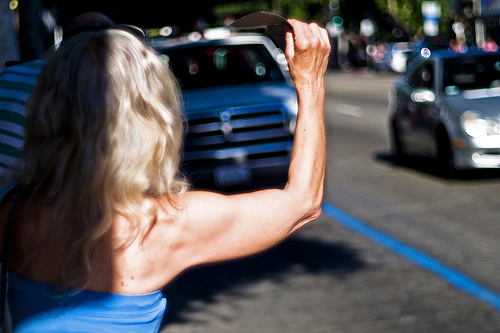

In [80]:
try_image = test_img[0]
Image.open(try_image)

In [ ]:
print ('Description:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))